In [ ]:
pip install torchinfo

In [ ]:
import os
import random
from shutil import copy2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device.")

Using cuda device.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/DeepLeanrning/Agriculture_project/", "Agricultural-crops")

In [ ]:
print("Data Directory:", data_dir)

Data Directory: /content/drive/MyDrive/Colab Notebooks/DeepLeanrning/Agriculture_project/Agricultural-crops


In [ ]:
classes = os.listdir(data_dir)
print("Classes:", classes)

Classes: ['banana', 'almond', 'clove', 'cotton', 'coconut', 'Cherry', 'chilli', 'cardamom', 'Coffee-plant', 'Cucumber', 'Fox_nut(Makhana)', 'jowar', 'gram', 'jute', 'mustard-oil', 'Lemon', 'maize', 'Olive-tree', 'Pearl_millet(bajra)', 'papaya', 'pineapple', 'rice', 'sunflower', 'soyabean', 'tea', 'sugarcane', 'tomato', 'Tobacco-plant', 'wheat', 'vigna-radiati(Mung)']


In [ ]:
class ConvertToRGB(object):
  def __call__(self, image):
    if image.mode != "RGB":
      image = image.convert(mode="RGB")
    return image

In [ ]:
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize(size=(380, 380)),
    transforms.ToTensor()
])

In [ ]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [ ]:
data_loader = DataLoader(dataset, batch_size=32)

In [ ]:
def get_mean_std(loader):
  channels_sum, channels_squared_sum, num_batches = 0,0,0
  for data, _ in tqdm(loader):
    channels_sum += torch.mean(data, dim=[0,2,3])
    channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
    num_batches +=1
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
  return mean, std

In [ ]:
mean, std = get_mean_std(data_loader)
print(mean, std)

  0%|          | 0/26 [00:00<?, ?it/s]

tensor([0.4782, 0.5156, 0.3332]) tensor([0.2537, 0.2383, 0.2710])


In [ ]:
#import shutil
#shutil.rmtree("/content/drive/MyDrive/Colab Notebooks/DeepLeanrning/Agriculture_project/undersampled")

In [ ]:
transform_norm = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize(size=(380, 380)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
norm_dataset = datasets.ImageFolder(root=data_dir, transform=transform_norm)

norm_dataloader = DataLoader(norm_dataset, batch_size=32)

In [ ]:
new_mean, new_std = get_mean_std(norm_dataloader)

  0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
print(new_mean, new_std)

tensor([ 2.0862e-07, -2.0747e-07,  4.3557e-08]) tensor([1.0000, 1.0000, 1.0000])


In [ ]:
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset, (0.8, 0.2), generator=g)

print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

percent_train = np.round(100 * len(train_dataset) / len(norm_dataset), 2)
percent_val = np.round(100 * len(val_dataset) / len(norm_dataset), 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Length of training dataset: 664
Length of validation dataset: 165
Train data is 80.1% of full data
Validation data is 19.9% of full data


In [ ]:
from collections import Counter
import pandas as pd
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    try:
        class_to_index = dataset.class_to_idx
    except AttributeError:
        class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [ ]:
train_counts = class_counts(train_dataset)
val_counts = class_counts(val_dataset)

  0%|          | 0/664 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

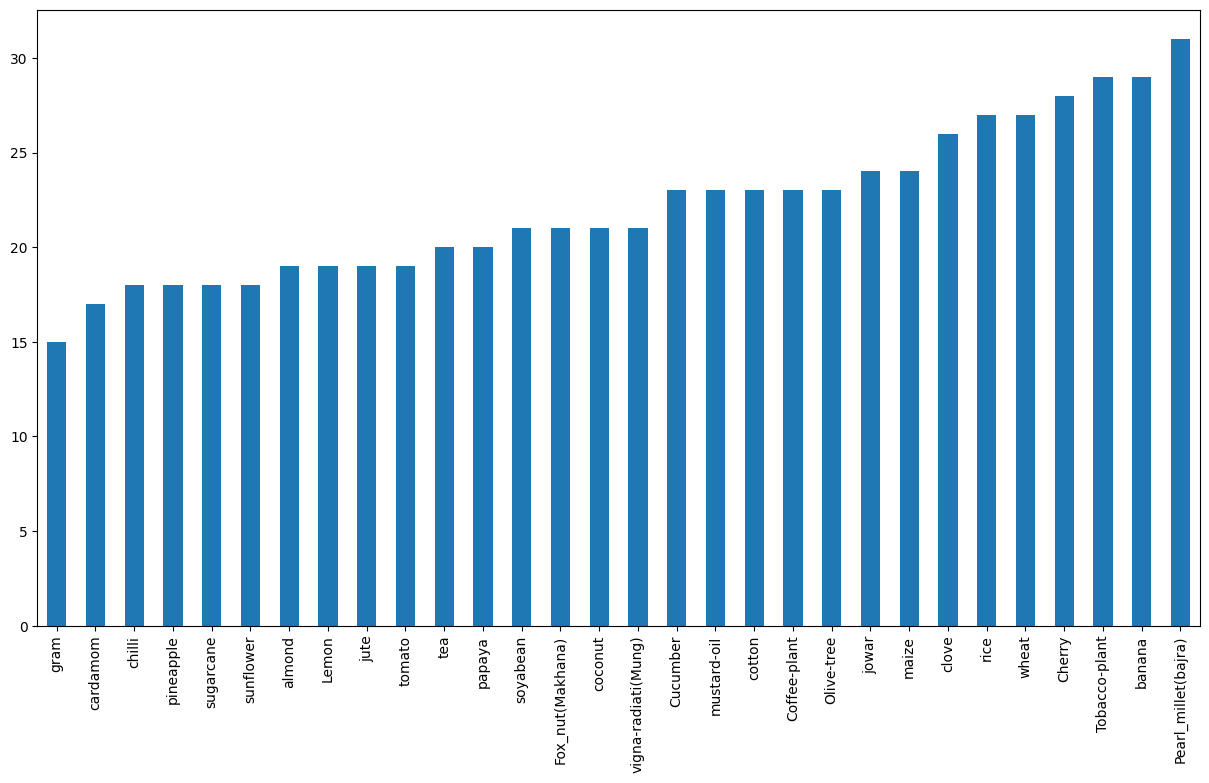

In [ ]:
plt.figure(figsize=(15,8))
train_counts.sort_values().plot(kind="bar");

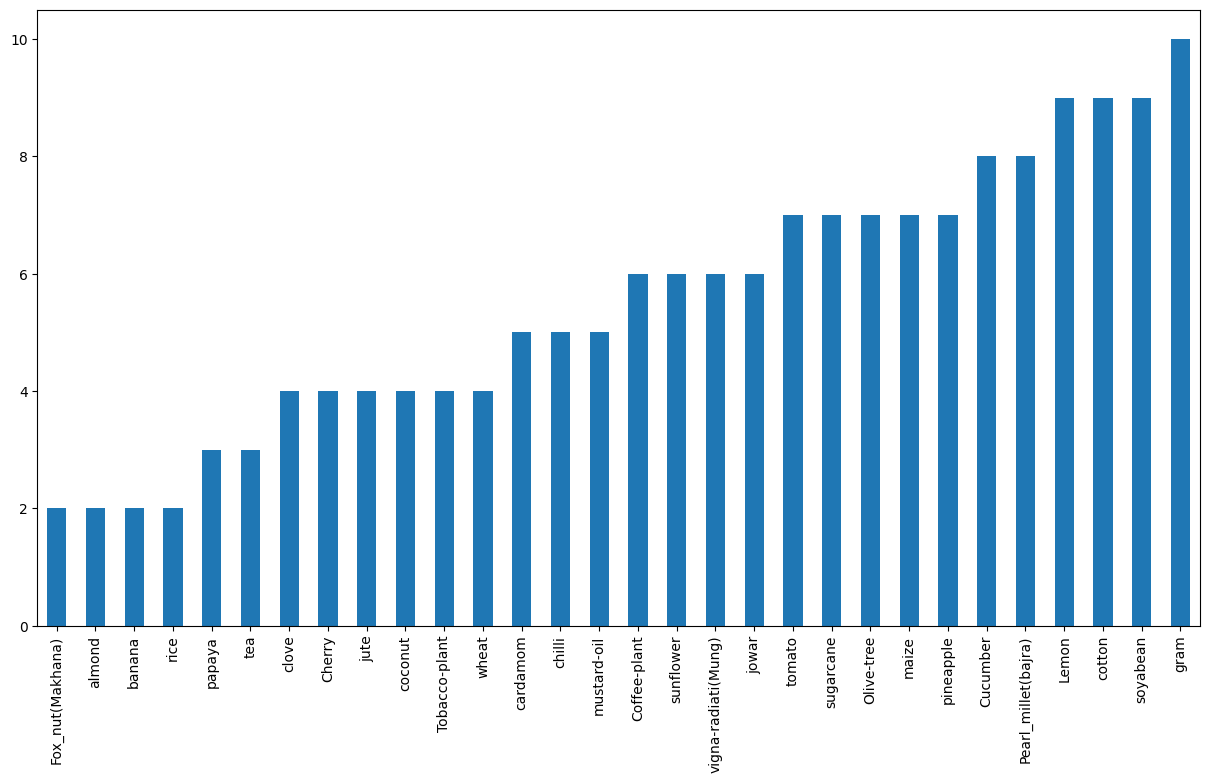

In [ ]:
plt.figure(figsize=(15,8))
val_counts.sort_values().plot(kind="bar");

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
test_batch = next(iter(train_loader))[0]
batch_shape = test_batch.shape

print(f"Batch shape: {batch_shape}")

Batch shape: torch.Size([32, 3, 380, 380])


In [ ]:
model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)

In [ ]:
summary(model, input_size=batch_shape)

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1792, 12, 12]        --
│    └─Conv2dNormActivation: 2-1                        [32, 48, 190, 190]        --
│    │    └─Conv2d: 3-1                                 [32, 48, 190, 190]        1,296
│    │    └─BatchNorm2d: 3-2                            [32, 48, 190, 190]        96
│    │    └─SiLU: 3-3                                   [32, 48, 190, 190]        --
│    └─Sequential: 2-2                                  [32, 24, 190, 190]        --
│    │    └─MBConv: 3-4                                 [32, 24, 190, 190]        2,940
│    │    └─MBConv: 3-5                                 [32, 24, 190, 190]        1,206
│    └─Sequential: 2-3                                  [32, 32, 95, 95]          --
│    │    └─MBConv: 3-6                            

In [ ]:
for params in model.parameters():
  params.requires_grad =False

In [ ]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
list(model.named_modules())[-1]

('classifier.1', Linear(in_features=1792, out_features=1000, bias=True))

In [ ]:
model.classifier[1].in_features

1792

In [ ]:
modified_model = nn.Sequential(
    nn.Linear(in_features=model.classifier[1].in_features, out_features=500),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=500, out_features=len(norm_dataset.classes))
)

In [ ]:
model.classifier = modified_model
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    training_loss = 0.0
    model.train()

    # Iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        training_loss += loss.data.item() * inputs.size(0)

    return training_loss / len(data_loader.dataset)

In [ ]:
def score(model, data_loader, loss_fn, device="cpu"):
    total_loss = 0
    total_correct = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    n_observations = data_loader.batch_size * len(data_loader)
    average_loss = total_loss / n_observations
    accuracy = total_correct / n_observations
    return average_loss, accuracy

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
from torch.optim.lr_scheduler import StepLR
step_size = 4
gamma = 0.2

scheduler = StepLR(
    optimizer,
    step_size=step_size,
    gamma=gamma,
)

In [ ]:
def early_stopping(validation_loss, best_val_loss, counter):
    """Function that implements Early Stopping"""

    stop = False

    if validation_loss < best_val_loss:
        counter = 0
    else:
        counter += 1


    if counter>=5:
        stop =True

    return counter, stop

In [ ]:
def checkpointing(validation_loss, best_val_loss, model, optimizer, save_path):

    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            },
            save_path,
        )

In [ ]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,
):

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []


    best_val_loss = float("inf")
    early_stopping_counter = 0

    print("Model evaluation before start of training.")

    train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    for epoch in range(1, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")


        train_epoch(model, optimizer, loss_fn, train_loader, device)


        train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)


        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.4f}%")
        print(f"Validation loss: {validation_loss:.4f}")
        print(f"Validation accuracy: {validation_accuracy*100:.4f}%")


        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step()


        if checkpoint_path:
            checkpointing(
                validation_loss, best_val_loss, model, optimizer, checkpoint_path
            )


        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                validation_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss

    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )

In [ ]:
import os

epochs_to_train = 50


checkpoint_dir = os.path.dirname("model/LR_model.pth")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

train_results = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path="model/LR_model.pth",
    early_stopping=early_stopping,
)

(
    learning_rates,
    train_losses,
    valid_losses,
    train_accuracies,
    valid_accuracies,
    epochs,
) = train_results

Model evaluation before start of training...


Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]



Starting epoch 1/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.8159
Training accuracy: 90.6250%
Validation loss: 1.1219
Validation accuracy: 63.5417%


Starting epoch 2/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.5671
Training accuracy: 93.7500%
Validation loss: 0.9082
Validation accuracy: 65.6250%


Starting epoch 3/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.3952
Training accuracy: 95.2381%
Validation loss: 0.7591
Validation accuracy: 68.2292%


Starting epoch 4/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.2897
Training accuracy: 96.7262%
Validation loss: 0.6707
Validation accuracy: 68.2292%


Starting epoch 5/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.2717
Training accuracy: 96.7262%
Validation loss: 0.6490
Validation accuracy: 68.7500%


Starting epoch 6/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 6
Training loss: 0.2557
Training accuracy: 96.8750%
Validation loss: 0.6465
Validation accuracy: 69.2708%


Starting epoch 7/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 7
Training loss: 0.2377
Training accuracy: 97.1726%
Validation loss: 0.6326
Validation accuracy: 70.3125%


Starting epoch 8/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 8
Training loss: 0.2160
Training accuracy: 97.3214%
Validation loss: 0.6095
Validation accuracy: 69.7917%


Starting epoch 9/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 9
Training loss: 0.2187
Training accuracy: 97.3214%
Validation loss: 0.6134
Validation accuracy: 70.3125%


Starting epoch 10/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 10
Training loss: 0.2148
Training accuracy: 97.1726%
Validation loss: 0.6079
Validation accuracy: 69.7917%


Starting epoch 11/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 11
Training loss: 0.2055
Training accuracy: 97.3214%
Validation loss: 0.6044
Validation accuracy: 69.7917%


Starting epoch 12/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 12
Training loss: 0.2060
Training accuracy: 97.6190%
Validation loss: 0.5996
Validation accuracy: 70.3125%


Starting epoch 13/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 13
Training loss: 0.2108
Training accuracy: 97.3214%
Validation loss: 0.6013
Validation accuracy: 70.3125%


Starting epoch 14/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 14
Training loss: 0.2066
Training accuracy: 97.4702%
Validation loss: 0.5945
Validation accuracy: 70.8333%


Starting epoch 15/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 15
Training loss: 0.2071
Training accuracy: 97.3214%
Validation loss: 0.6043
Validation accuracy: 70.8333%


Starting epoch 16/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 16
Training loss: 0.2075
Training accuracy: 97.4702%
Validation loss: 0.5980
Validation accuracy: 70.8333%


Starting epoch 17/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 17
Training loss: 0.2126
Training accuracy: 97.3214%
Validation loss: 0.6084
Validation accuracy: 71.3542%


Starting epoch 18/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 18
Training loss: 0.2057
Training accuracy: 97.4702%
Validation loss: 0.6065
Validation accuracy: 70.8333%


Starting epoch 19/50


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 19
Training loss: 0.2002
Training accuracy: 97.3214%
Validation loss: 0.5985
Validation accuracy: 70.3125%
Early stopping triggered after 19 epochs


In [ ]:
eval_metrics_df = pd.DataFrame(
    {
        "Epoch": list(range(1, epochs + 1)),
        "Training Loss": train_losses[1:],
        "Validation Loss": valid_losses[1:],
        "Training Accuracy": train_accuracies[1:],
        "Validation Accuracy": valid_accuracies[1:],
        "Learning Rate": learning_rates,
    })


In [ ]:
eval_metrics_df.head()

Epoch  Training Loss  Validation Loss  Training Accuracy  \
0      1       0.815905         1.121897           0.906250   
1      2       0.567143         0.908219           0.937500   
2      3       0.395184         0.759098           0.952381   
3      4       0.289674         0.670673           0.967262   
4      5       0.271669         0.648998           0.967262   

   Validation Accuracy  Learning Rate  
0             0.635417         0.0010  
1             0.656250         0.0010  
2             0.682292         0.0010  
3             0.682292         0.0010  
4             0.687500         0.0002

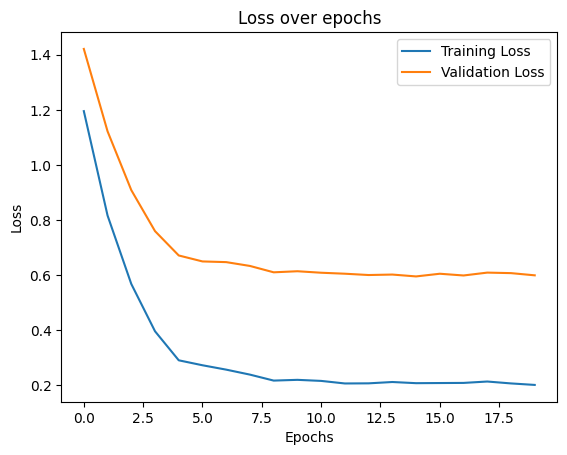

In [ ]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

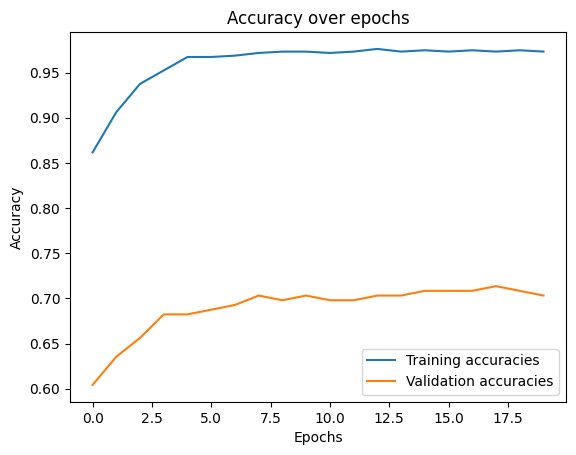

In [ ]:
plt.plot(train_accuracies, label="Training accuracies")


plt.plot(valid_accuracies, label="Validation accuracies")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

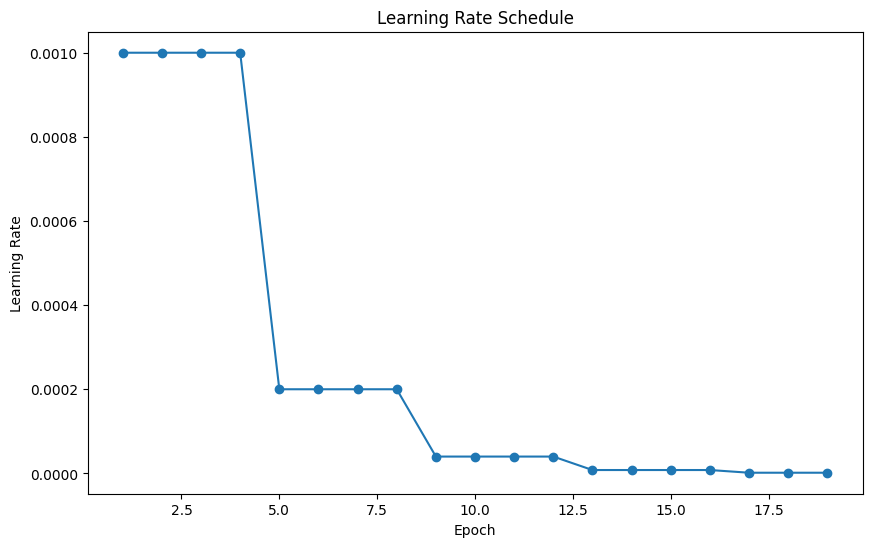

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), learning_rates, marker="o", label="Learning Rate")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
checkpoint = torch.load("model/LR_model.pth")

model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [ ]:
def predict(model, data_loader, device="cpu"):
    all_probs = torch.tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)
            probs = torch.nn.functional.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs

In [ ]:
prob = predict(model, val_loader, device)
pred = torch.argmax(prob, dim=1)

Predicting:   0%|          | 0/6 [00:00<?, ?it/s]

Get Labels:   0%|          | 0/6 [00:00<?, ?it/s]

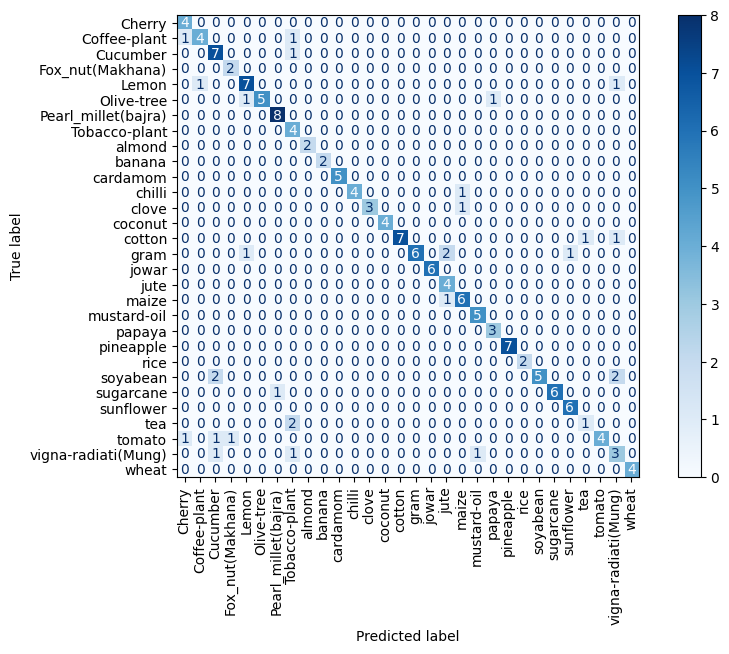

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
targets_val = torch.cat([labels for _, labels in tqdm(val_loader, desc="Get Labels")])

fig, ax = plt.subplots(figsize=(10, 6))

cm = confusion_matrix(targets_val.cpu(), pred.cpu())


classes = norm_dataset.classes


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)

In [ ]:
valid_classes = [classes[i] for i in pred]

print("Number of class predictions:", len(valid_classes))

Number of class predictions: 165


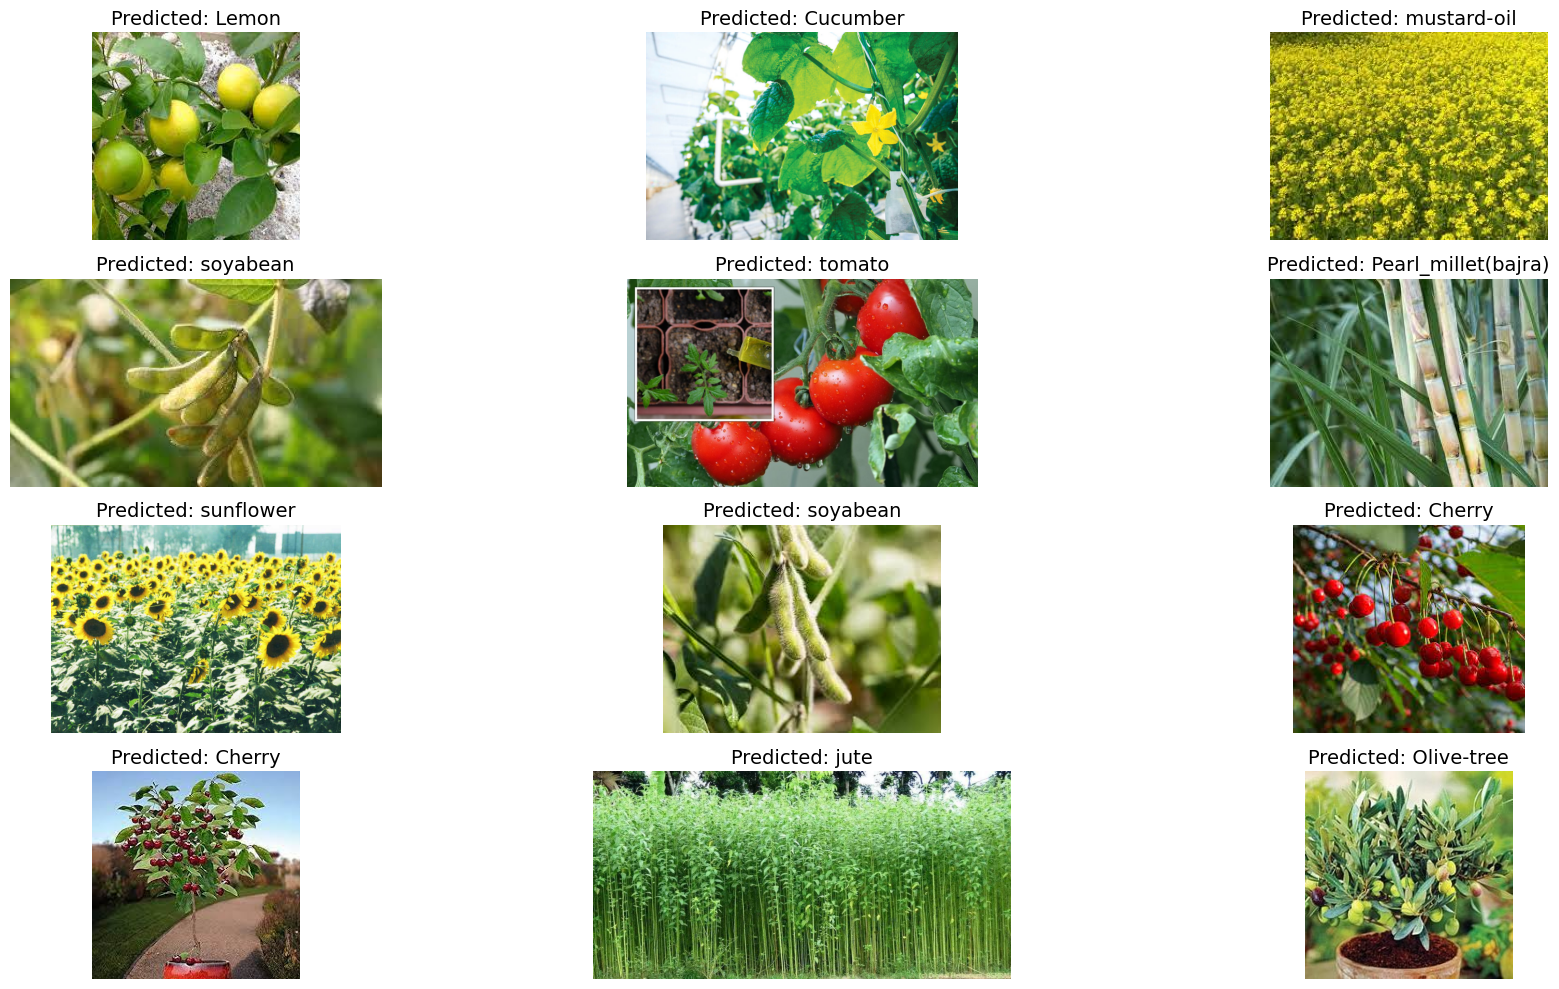

In [ ]:
from PIL import Image

sample_indices = random.sample(range(len(val_loader.dataset)), 12)


fig, axes = plt.subplots(4, 3, figsize=(20, 10))


for ax, idx in zip(axes.flatten(), sample_indices):
    image_path = val_loader.dataset.dataset.samples[val_loader.dataset.indices[idx]][0]
    img = Image.open(image_path)


    ax.imshow(img)
    ax.axis('off')


    predicted_class = valid_classes[idx]


    ax.set_title(f"Predicted: {predicted_class}", fontsize=14)

plt.tight_layout()

In [ ]:
def undersample_dataset(dataset_dir, output_dir, target_count=None):

    classes_files = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            files = os.listdir(class_dir)
            classes_files[class_name] = files


    if target_count is None:
        target_count = min(len(files) for files in classes_files.values())


    if not os.path.exists(output_dir):
        os.makedirs(output_dir)


    for class_name, files in classes_files.items():
        print("Copying images for class", class_name)
        class_output_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(class_output_dir):
            os.makedirs(class_output_dir)


        selected_files = random.sample(files, min(len(files), target_count))


        for file_name in tqdm(selected_files):
            src_path = os.path.join(dataset_dir, class_name, file_name)
            dst_path = os.path.join(class_output_dir, file_name)
            copy2(src_path, dst_path)

    print(f"Undersampling completed. Each class has up to {target_count} instances.")

In [ ]:
output_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/DeepLeanrning/Agriculture_project/", "undersampled")
undersample_dataset(data_dir, output_dir)

Copying images for class banana


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class almond


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class clove


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class cotton


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class coconut


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class Cherry


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class chilli


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class cardamom


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class Coffee-plant


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class Cucumber


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class Fox_nut(Makhana)


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class jowar


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class gram


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class jute


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class mustard-oil


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class Lemon


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class maize


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class Olive-tree


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class Pearl_millet(bajra)


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class papaya


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class pineapple


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class rice


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class sunflower


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class soyabean


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class tea


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class sugarcane


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class tomato


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class Tobacco-plant


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class wheat


  0%|          | 0/21 [00:00<?, ?it/s]

Copying images for class vigna-radiati(Mung)


  0%|          | 0/21 [00:00<?, ?it/s]

Undersampling completed. Each class has up to 21 instances.


In [ ]:
undersample_dataset = datasets.ImageFolder(root=output_dir, transform=transform_norm)

In [ ]:
undersample_dataset.classes

['Cherry',
 'Coffee-plant',
 'Cucumber',
 'Fox_nut(Makhana)',
 'Lemon',
 'Olive-tree',
 'Pearl_millet(bajra)',
 'Tobacco-plant',
 'almond',
 'banana',
 'cardamom',
 'chilli',
 'clove',
 'coconut',
 'cotton',
 'gram',
 'jowar',
 'jute',
 'maize',
 'mustard-oil',
 'papaya',
 'pineapple',
 'rice',
 'soyabean',
 'sugarcane',
 'sunflower',
 'tea',
 'tomato',
 'vigna-radiati(Mung)',
 'wheat']

  0%|          | 0/630 [00:00<?, ?it/s]

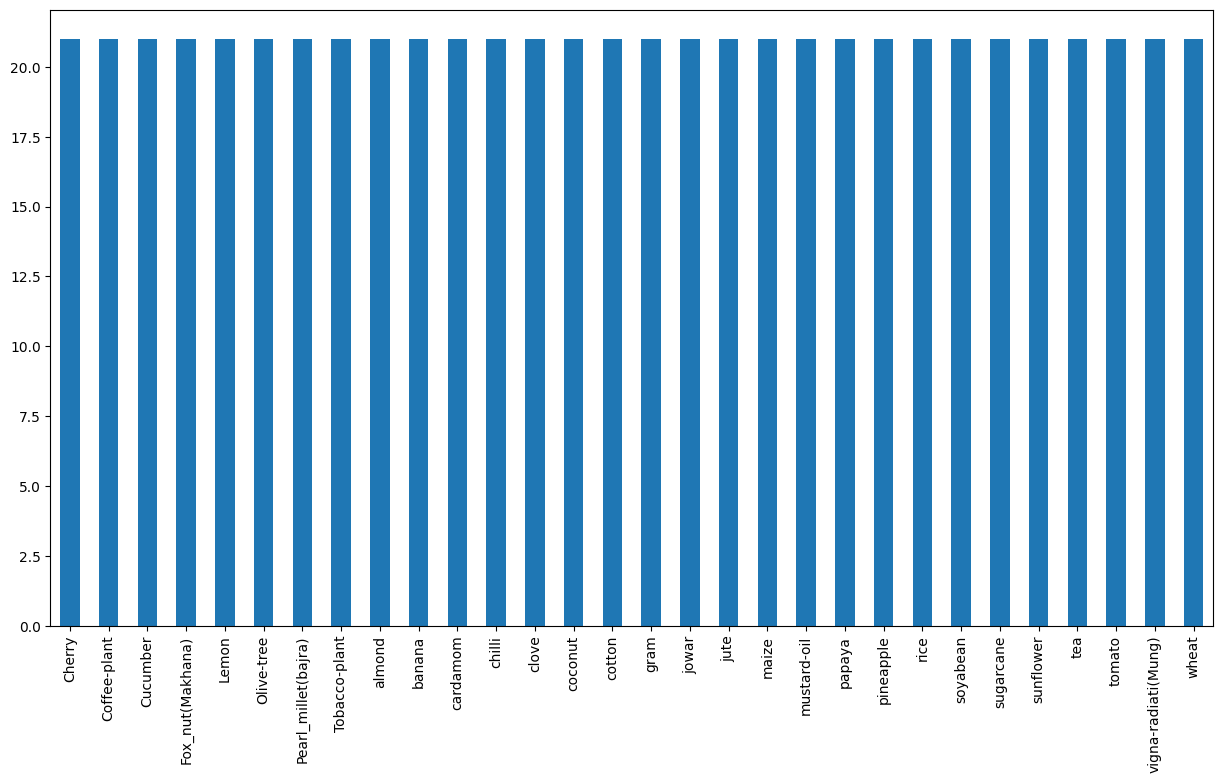

In [ ]:
plt.figure(figsize=(15,8))
class_counts(undersample_dataset).plot(kind="bar");

In [ ]:
undersample_dataloader = DataLoader(undersample_dataset, batch_size=32)

In [ ]:
train_data, val_data = random_split(undersample_dataset, (0.8, 0.2))

print("Length of training dataset:", len(train_data))
print("Length of validation dataset:", len(val_data))

Length of training dataset: 504
Length of validation dataset: 126


  0%|          | 0/504 [00:00<?, ?it/s]

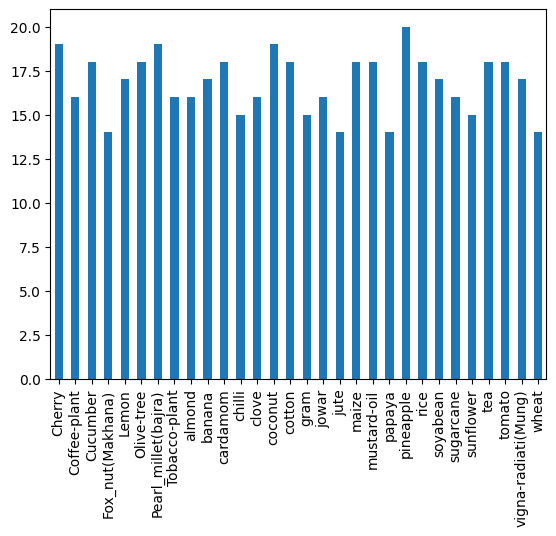

In [ ]:
train_data_count = class_counts(train_data)
train_data_count.plot(kind="bar");

  0%|          | 0/126 [00:00<?, ?it/s]

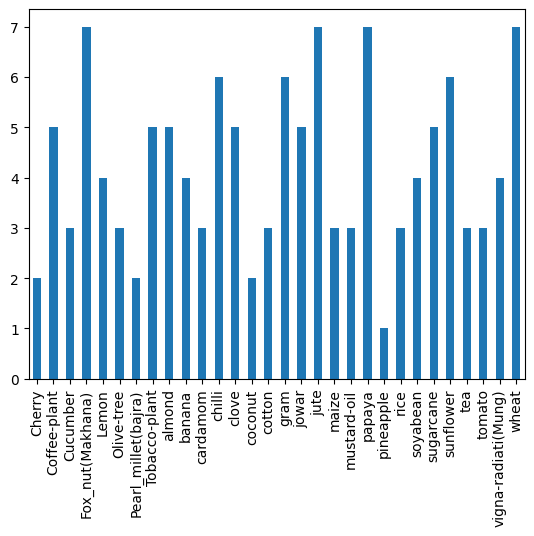

In [ ]:
val_data_count = class_counts(val_data)
val_data_count.plot(kind="bar");

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)

print(type(train_dataloader))
print(type(val_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
epochs_to_train = 50


checkpoint_dir = os.path.dirname("model/LR2_model.pth")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

train_results_u = train(
    model,
    optimizer,
    loss_fn,
    train_dataloader,
    val_dataloader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path="model/LR_model.pth",
    early_stopping=early_stopping,
)

(
    learning_rates_u,
    train_losses_u,
    valid_losses_u,
    train_accuracies_u,
    valid_accuracies_u,
    epochs,
) = train_results_u

Model evaluation before start of training...


Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]



Starting epoch 1/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.3183
Training accuracy: 93.9453%
Validation loss: 0.3193
Validation accuracy: 96.0938%


Starting epoch 2/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.3126
Training accuracy: 93.7500%
Validation loss: 0.3116
Validation accuracy: 96.0938%


Starting epoch 3/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.3089
Training accuracy: 93.9453%
Validation loss: 0.3122
Validation accuracy: 96.0938%


Starting epoch 4/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.3180
Training accuracy: 93.5547%
Validation loss: 0.3264
Validation accuracy: 95.3125%


Starting epoch 5/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.3132
Training accuracy: 93.7500%
Validation loss: 0.3182
Validation accuracy: 95.3125%


Starting epoch 6/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 6
Training loss: 0.3079
Training accuracy: 93.9453%
Validation loss: 0.3110
Validation accuracy: 96.0938%


Starting epoch 7/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 7
Training loss: 0.3090
Training accuracy: 93.9453%
Validation loss: 0.3142
Validation accuracy: 95.3125%


Starting epoch 8/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 8
Training loss: 0.3056
Training accuracy: 93.7500%
Validation loss: 0.3079
Validation accuracy: 96.0938%


Starting epoch 9/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 9
Training loss: 0.3074
Training accuracy: 93.7500%
Validation loss: 0.3073
Validation accuracy: 96.0938%


Starting epoch 10/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 10
Training loss: 0.3038
Training accuracy: 93.5547%
Validation loss: 0.3056
Validation accuracy: 96.0938%


Starting epoch 11/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 11
Training loss: 0.3052
Training accuracy: 93.5547%
Validation loss: 0.3045
Validation accuracy: 96.0938%


Starting epoch 12/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 12
Training loss: 0.3070
Training accuracy: 93.7500%
Validation loss: 0.3070
Validation accuracy: 96.0938%


Starting epoch 13/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 13
Training loss: 0.3062
Training accuracy: 94.1406%
Validation loss: 0.3112
Validation accuracy: 96.0938%


Starting epoch 14/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 14
Training loss: 0.3047
Training accuracy: 93.3594%
Validation loss: 0.3070
Validation accuracy: 96.0938%


Starting epoch 15/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 15
Training loss: 0.3091
Training accuracy: 93.7500%
Validation loss: 0.3113
Validation accuracy: 96.0938%


Starting epoch 16/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 16
Training loss: 0.3106
Training accuracy: 93.9453%
Validation loss: 0.3177
Validation accuracy: 96.0938%
Early stopping triggered after 16 epochs


In [ ]:
eval_metrics_under_df = pd.DataFrame(
    {
        "Epoch": list(range(1, epochs + 1)),
        "Training Loss": train_losses_u[1:],
        "Validation Loss": valid_losses_u[1:],
        "Training Accuracy": train_accuracies_u[1:],
        "Validation Accuracy": valid_accuracies_u[1:],
        "Learning Rate": learning_rates_u,
    })


In [ ]:
eval_metrics_under_df.head()

Epoch  Training Loss  Validation Loss  Training Accuracy  \
0      1       0.318345         0.319336           0.939453   
1      2       0.312619         0.311633           0.937500   
2      3       0.308899         0.312250           0.939453   
3      4       0.318023         0.326414           0.935547   
4      5       0.313211         0.318184           0.937500   

   Validation Accuracy  Learning Rate  
0             0.960938       0.000008  
1             0.960938       0.000002  
2             0.960938       0.000002  
3             0.953125       0.000002  
4             0.953125       0.000002

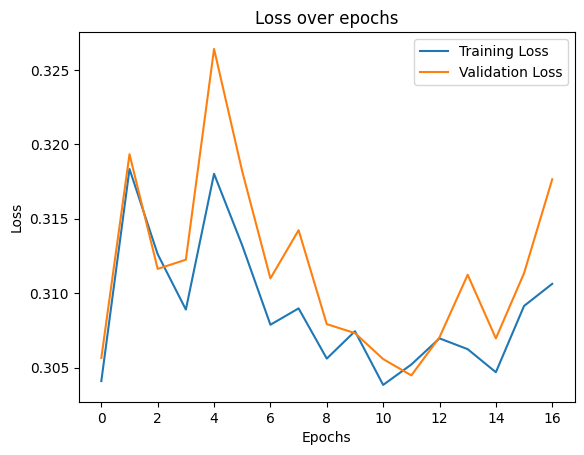

In [ ]:
plt.plot(train_losses_u, label="Training Loss")
plt.plot(valid_losses_u, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

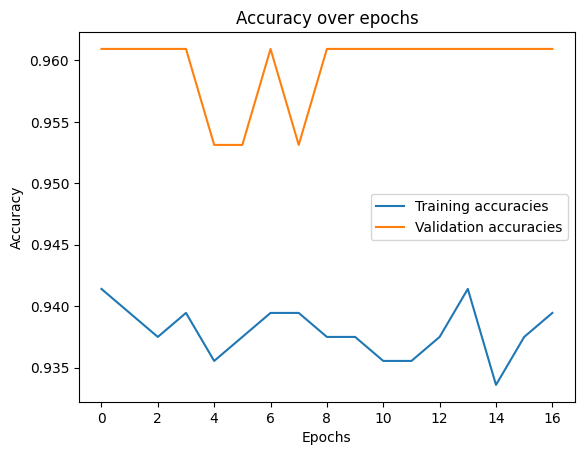

In [ ]:
plt.plot(train_accuracies_u, label="Training accuracies")

# Plot validation accuracies, use label="Validation Accuracy"
plt.plot(valid_accuracies_u, label="Validation accuracies")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

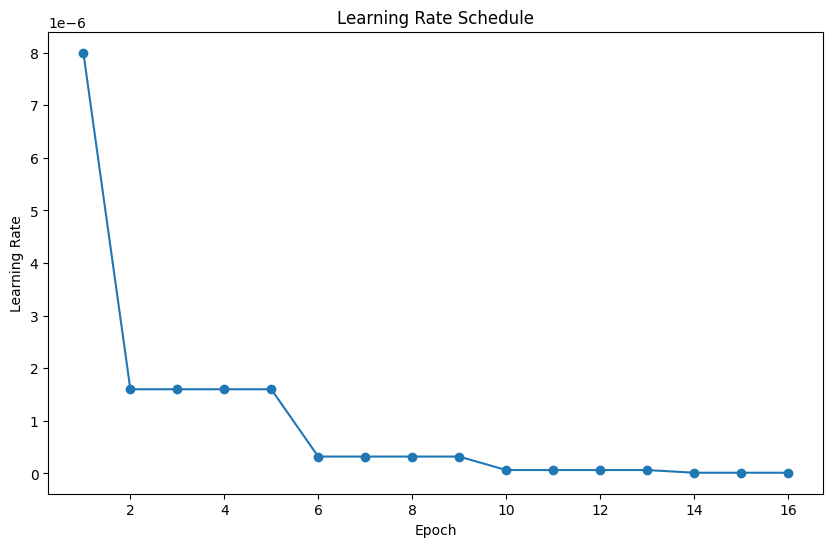

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), learning_rates_u, marker="o", label="Learning Rate")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
checkpoint_u = torch.load("model/LR_model.pth")

model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [ ]:
probabilities = predict(model, val_dataloader, device)

Predicting:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
predictions = torch.argmax(probabilities, dim=1)

In [ ]:
targets = []

for _, labels in tqdm(val_dataloader):
    targets.extend(labels.tolist())

  0%|          | 0/4 [00:00<?, ?it/s]

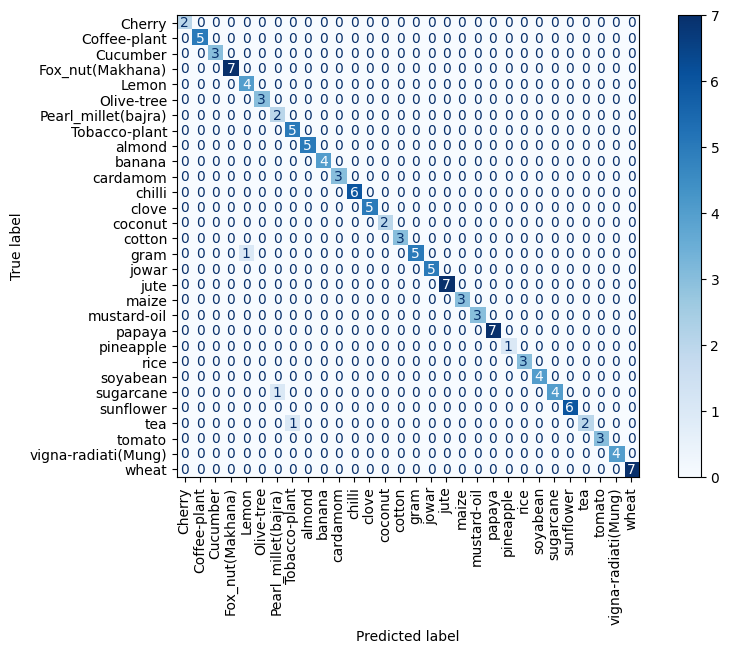

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(figsize=(10, 6))

cm = confusion_matrix(targets, predictions.cpu())

classes = undersample_dataset.classes

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)

In [ ]:
val_classes = [classes[i] for i in predictions]

print("Number of class predictions:", len(val_classes))

Number of class predictions: 126


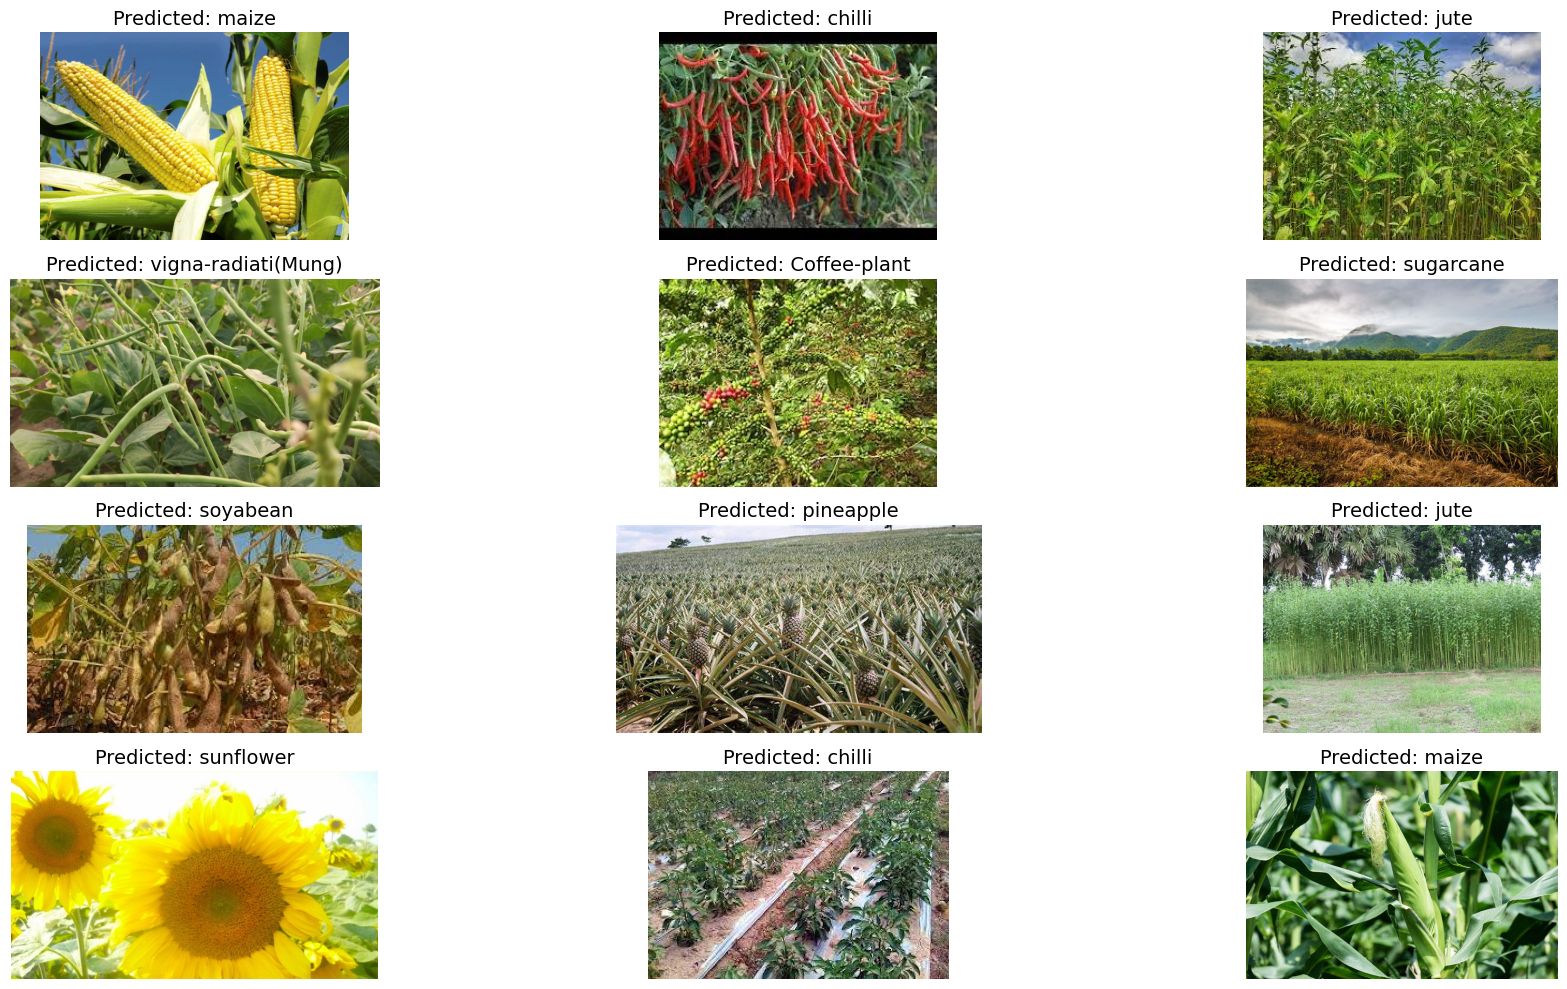

In [ ]:
from PIL import Image

sample_indices = random.sample(range(len(val_dataloader.dataset)), 24)


fig, axes = plt.subplots(4, 3, figsize=(20, 10))


for ax, idx in zip(axes.flatten(), sample_indices):
    image_path = val_dataloader.dataset.dataset.samples[val_dataloader.dataset.indices[idx]][0]
    img = Image.open(image_path)


    ax.imshow(img)
    ax.axis('off')


    predicted_class = val_classes[idx]


    ax.set_title(f"Predicted: {predicted_class}", fontsize=14)

plt.tight_layout()